[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alanlin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/alanlin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


train.csv shape is :  (1697533, 9)
test.csv shape is :  (212192, 2)


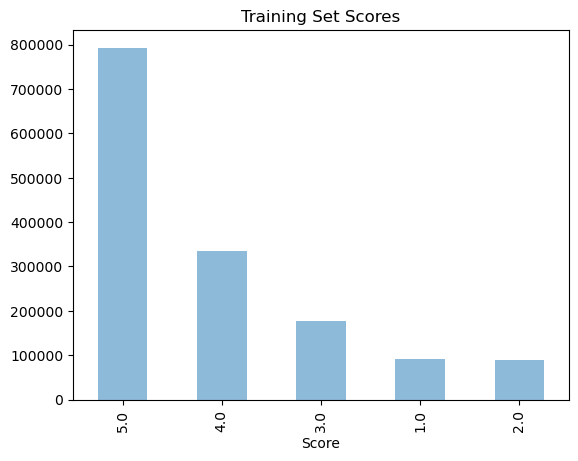

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
Accuracy on testing set =  0.6912014994506324


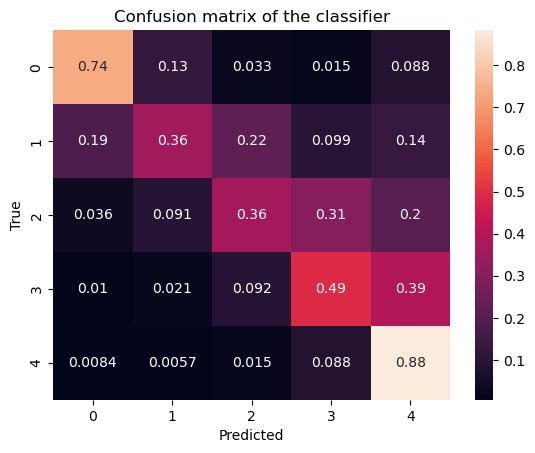

In [2]:
# Libraries
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('punkt')
sia = SentimentIntensityAnalyzer()

#-----------------------------------------------------------
# LOADING THE FILES
trainingSet = pd.read_csv('data/train.csv')
testingSet = pd.read_csv('data/test.csv')

print('train.csv shape is : ', trainingSet.shape)
print('test.csv shape is : ', testingSet.shape)

trainingSet['Score'].value_counts().plot(kind='bar', title='Training Set Scores', alpha=0.5)
plt.show()

#-----------------------------------------------------------
# ADDING THE FEATURES
def calculate_sentiment(text):
    if isinstance(text, str):
        return sia.polarity_scores(text)['compound']
    else:
        return 0

def calculate_user_features(df):
    user_stats = df.groupby('UserId').agg({
        'Score': ['mean', 'std', 'count']
    }).reset_index()

    user_stats.columns = ['UserId', 'User_mean_score', 'User_std_score', 'User_review_count']
    user_stats['User_std_score'] = user_stats['User_std_score'].fillna(0)
    
    df = df.merge(user_stats, on='UserId', how='left')
    
    return df

def calculate_product_features(df):
    product_stats = df.groupby('ProductId').agg({
        'Score': ['mean', 'std', 'count']
    }).reset_index()
    
    product_stats.columns = ['ProductId', 'Product_mean_score', 'Product_std_score', 'Product_review_count']
    product_stats['Product_std_score'] = product_stats['Product_std_score'].fillna(0)
    
    df = df.merge(product_stats, on='ProductId', how='left')
    
    return df

def add_features_to(df, training_scores=None):
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'].clip(lower=1)
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    df['Review_Length'] = df['Text'].str.len()
    df['Review_Length'] = df['Review_Length'].fillna(0)

    df['Sentiment_Score'] = df['Text'].apply(calculate_sentiment)
    df['Summary_Sentiment_Score'] = df['Summary'].apply(calculate_sentiment)

    df = calculate_user_features(df)
    df = calculate_product_features(df)
    
    df['User_mean_score'] = df['User_mean_score'].fillna(df['User_mean_score'].mean())
    df['User_std_score'] = df['User_std_score'].fillna(df['User_std_score'].mean())
    df['User_review_count'] = df['User_review_count'].fillna(1)
    
    df['Product_mean_score'] = df['Product_mean_score'].fillna(df['Product_mean_score'].mean())
    df['Product_std_score'] = df['Product_std_score'].fillna(df['Product_std_score'].mean())
    df['Product_review_count'] = df['Product_review_count'].fillna(1)
    
    return df

if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    train = add_features_to(trainingSet)

    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

#-----------------------------------------------------------
# SAMPLING AND SPLITTING THE DATA
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'] - 1, 
    test_size=(1/4.0),
    random_state=0
)

#-----------------------------------------------------------
# SELECTING THE FEATURES
features = [
    'Sentiment_Score', 'Summary_Sentiment_Score', 'HelpfulnessNumerator',
    'HelpfulnessDenominator', 'Helpfulness', 'Review_Length', 
    'User_mean_score', 'User_review_count', 'User_std_score',
    'Product_mean_score', 'Product_review_count', 'Product_std_score'
]

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

#-----------------------------------------------------------
# APPLYING GRIDSEARCHCV
param_grid = {
	'n_estimators': [100, 200],
	'learning_rate': [0.01, 0.1],
	'max_depth': [4, 6, 8],
	'subsample': [0.8, 1.0],
	'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
	estimator=XGBClassifier(random_state=42),
	param_grid=param_grid,
	scoring='accuracy',
	cv=3,
	verbose=1
)

grid_search.fit(X_train_select, Y_train)

best_model = grid_search.best_estimator_

#-----------------------------------------------------------
# MODEL EVALUATION
Y_test_predictions = best_model.predict(X_test_select)
print("Best Parameters:", grid_search.best_params_)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#-----------------------------------------------------------
# CREATING THE SUBMISSION FILE
X_submission['Score'] = best_model.predict(X_submission_select) + 1
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)